In [101]:
from spleeter.separator import Separator
import os
import librosa
from swift_f0 import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [102]:
import tensorflow as tf

tf.config.threading.set_intra_op_parallelism_threads(
    tf.config.threading.get_intra_op_parallelism_threads() or 0
)
tf.config.threading.set_inter_op_parallelism_threads(2)

In [103]:
# inputs
# audio_path = '/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/RagaDataset/Hindustani/audio/Gaud Malhar/Gaud Malhar_3.mp3'
audio_path = '/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/audio/kalliyankat.mp3'
fusion = True  # whether song is fusion or pure classical

output_dir = 'separated_stems'        # saved stems directory

filename = os.path.splitext(os.path.basename(audio_path))[0]
stem_dir = os.path.join(output_dir, filename)

# only run separation if the folder doesn't already exist
if not os.path.isdir(stem_dir):
    separator = Separator('spleeter:2stems')
    separator.separate_to_file(audio_path, output_dir)
else:
    print(f"Skipping separation: '{stem_dir}' already exists.")

# set the paths
vocals_path = os.path.join(stem_dir, 'vocals.wav')
accompaniment_path = os.path.join(stem_dir, 'accompaniment.wav')

print("Vocals:", vocals_path)
print("Accompaniment:", accompaniment_path)


Skipping separation: 'separated_stems/kalliyankat' already exists.
Vocals: separated_stems/kalliyankat/vocals.wav
Accompaniment: separated_stems/kalliyankat/accompaniment.wav


-------Vocal analysis--------
[LOAD CSV] vocals_pitch_data.csv -> PitchResult (frames=23170, voiced=7485)


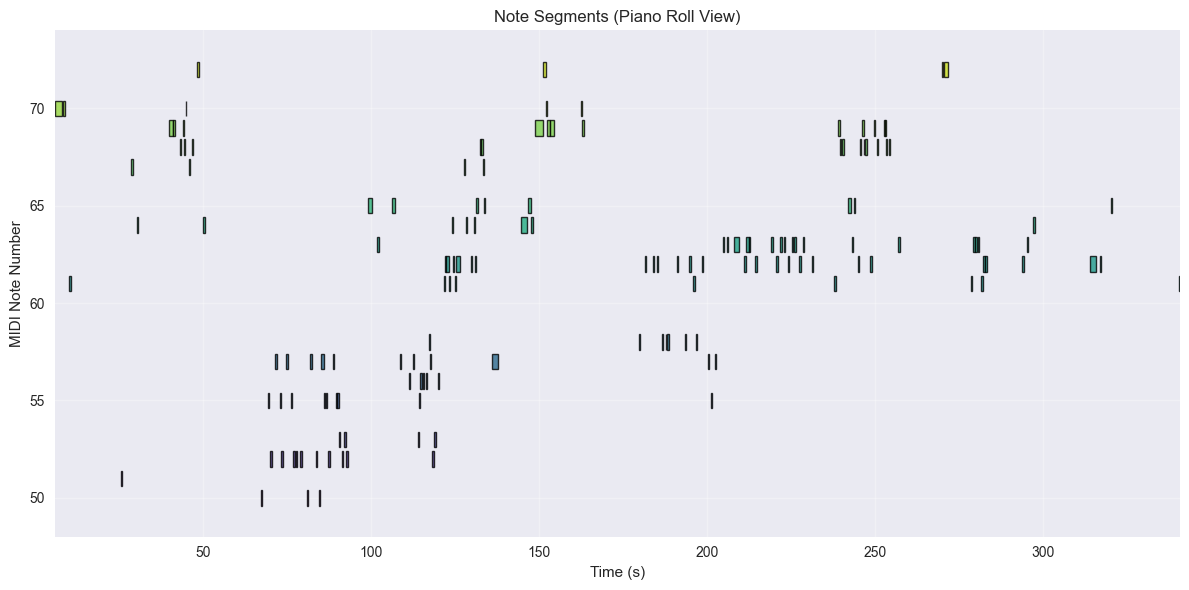

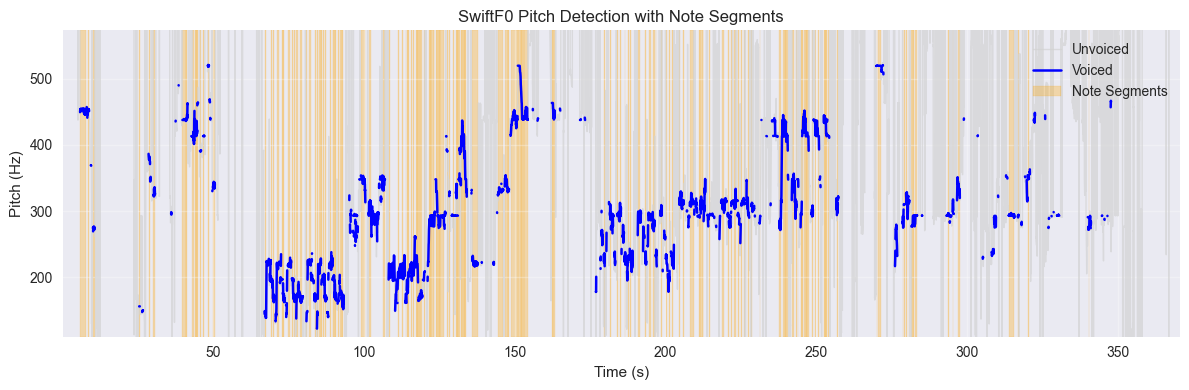

[LOAD] MIDI npy loaded: separated_stems/kalliyankat/vocals_midi.npy (len=7485)

vocals — voiced (valid) frames: 7485
MIDI preview (first up to 40): [69.37000274658203, 69.43000030517578, 69.4800033569336, 69.5, 69.52999877929688, 69.55000305175781, 69.55000305175781, 69.52999877929688, 69.48999786376953, 69.41999816894531, 69.43000030517578, 69.4800033569336, 69.54000091552734, 69.55999755859375, 69.55999755859375, 69.55999755859375, 69.55999755859375, 69.55999755859375, 69.55000305175781, 69.51000213623047, 69.45999908447266, 69.44999694824219, 69.4800033569336, 69.45999908447266, 69.43000030517578, 69.4800033569336, 69.5199966430664, 69.54000091552734, 69.54000091552734, 69.54000091552734, 69.54000091552734, 69.55000305175781, 69.55000305175781, 69.54000091552734, 69.54000091552734, 69.55000305175781, 69.55000305175781, 69.55000305175781, 69.55999755859375, 69.55999755859375]
Unique pitch-classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
MIDI mean 61.75, median 61.99, std 5.38



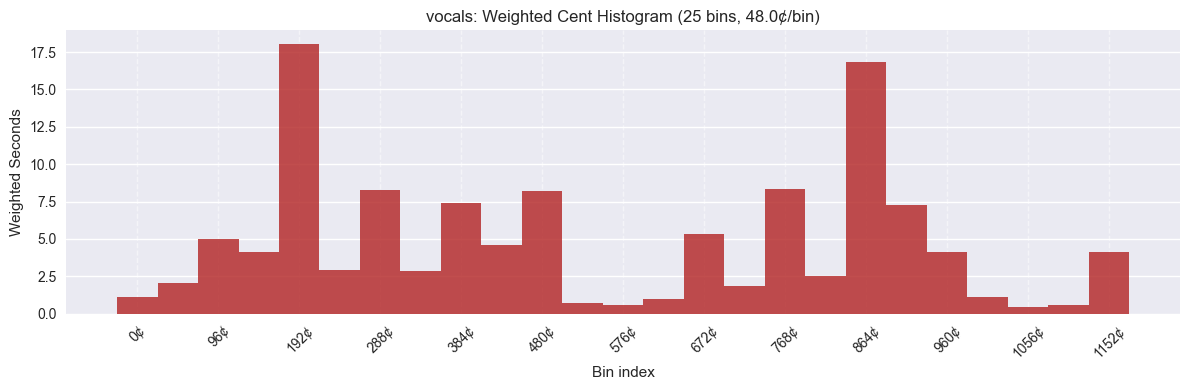

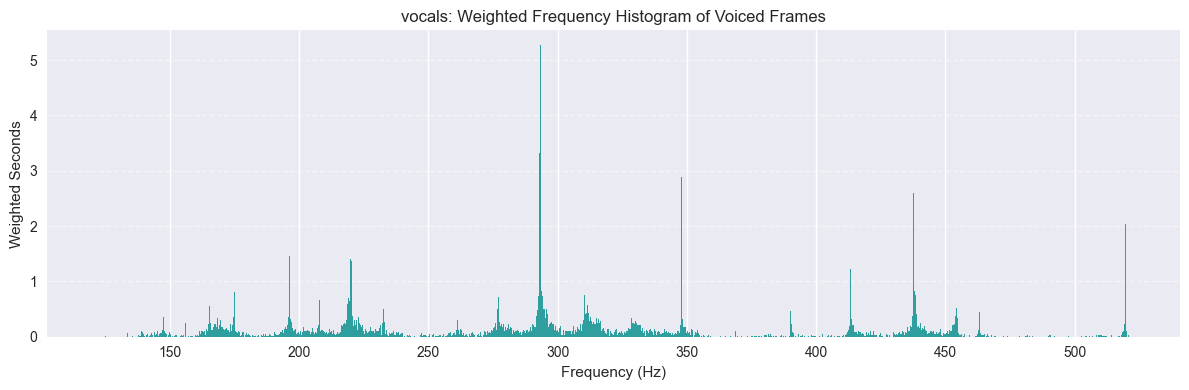

-------Accompaniment analysis --------
[LOAD CSV] accompaniment_pitch_data.csv -> PitchResult (frames=23170, voiced=8799)


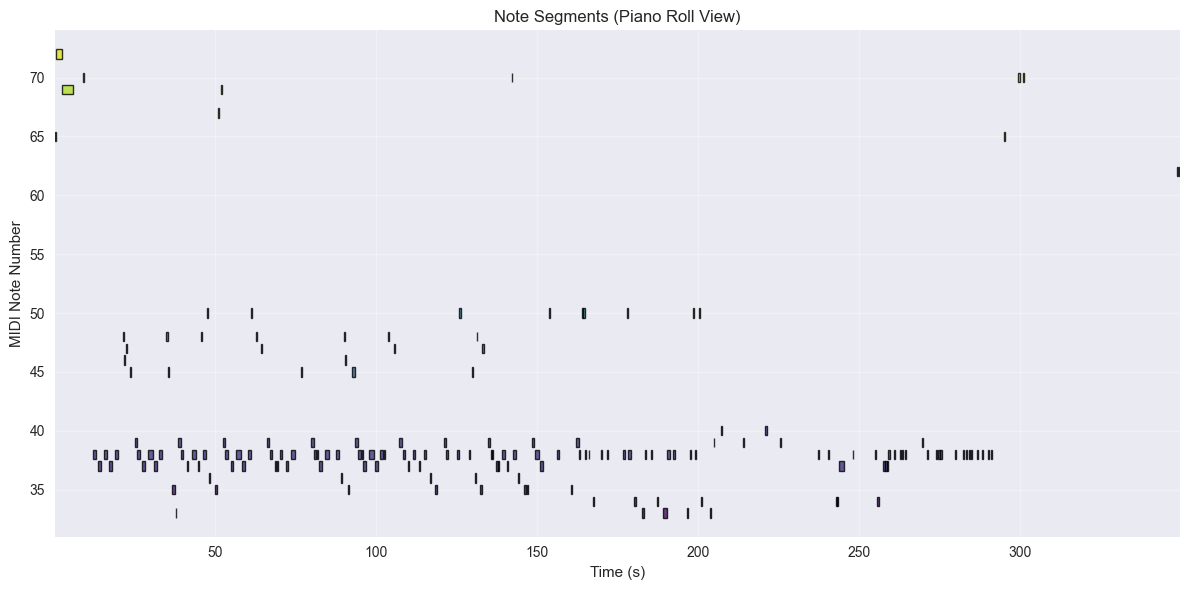

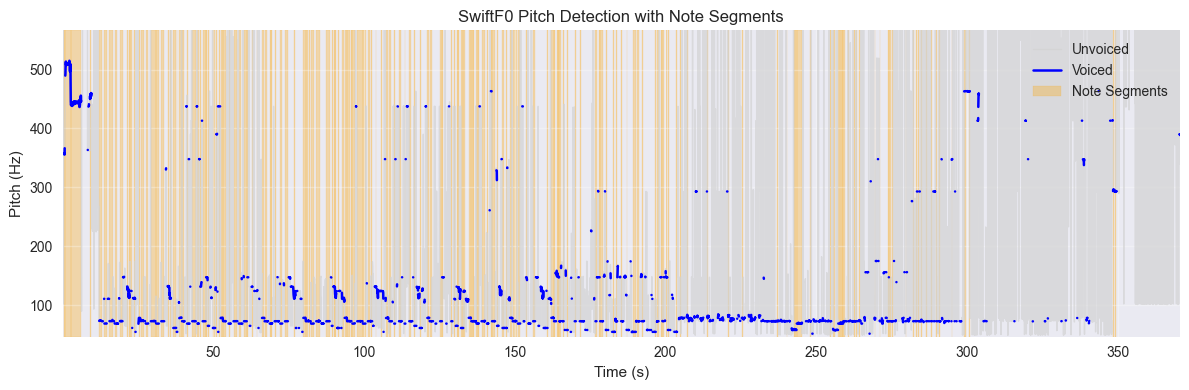

[LOAD] MIDI npy loaded: separated_stems/kalliyankat/accompaniment_midi.npy (len=8799)

accompaniment — voiced (valid) frames: 8799
MIDI preview (first up to 40): [65.37000274658203, 65.37000274658203, 65.37999725341797, 65.4000015258789, 65.4000015258789, 65.41999816894531, 65.41999816894531, 65.41000366210938, 65.41000366210938, 65.41000366210938, 65.41999816894531, 65.37000274658203, 65.31999969482422, 65.31999969482422, 65.3499984741211, 65.43000030517578, 65.56999969482422, 65.83000183105469, 70.86000061035156, 70.87999725341797, 70.88999938964844, 70.97000122070312, 71.18000030517578, 71.19999694824219, 71.27999877929688, 71.48999786376953, 71.58000183105469, 71.62999725341797, 71.6500015258789, 71.66000366210938, 71.68000030517578, 71.68000030517578, 71.6500015258789, 71.55000305175781, 71.51000213623047, 71.4800033569336, 71.48999786376953, 71.54000091552734, 71.55000305175781, 71.54000091552734]
Unique pitch-classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
MIDI mean 42.20, media

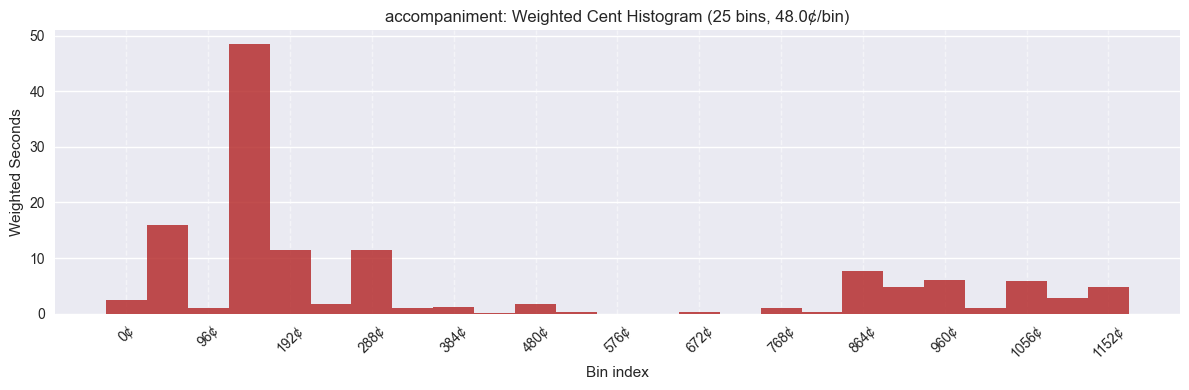

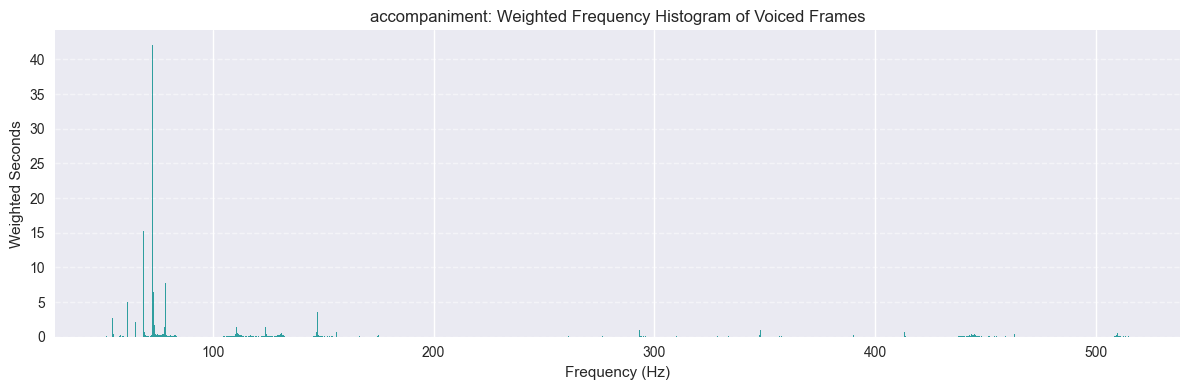

In [104]:
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

from swift_f0 import (
    SwiftF0,
    PitchResult,
    plot_pitch,
    export_to_csv,
    segment_notes,
    plot_notes,
    plot_pitch_and_notes,
    export_to_midi
)

def load_swiftf0_csv_as_pitchresult(csv_path, silent=False):
    """Load CSV exported by swift-f0 -> return PitchResult instance (defensive)."""
    df = pd.read_csv(csv_path)
    # Accept 'time' or 'timestamp' for timing, 'voiced' or 'voicing' for voiced flag
    ts_col = None
    if 'time' in df.columns:
        ts_col = 'time'
    elif 'timestamp' in df.columns:
        ts_col = 'timestamp'

    pitch_col = 'pitch_hz' if 'pitch_hz' in df.columns else None
    conf_col = 'confidence' if 'confidence' in df.columns else None
    voiced_col = 'voicing' if 'voicing' in df.columns else ('voiced' if 'voiced' in df.columns else None)

    if pitch_col is None or conf_col is None:
        raise ValueError(f"CSV {csv_path} missing required columns. Found: {list(df.columns)}")

    timestamps = pd.to_numeric(df[ts_col], errors='coerce').to_numpy() if ts_col else np.arange(len(df)).astype(float)
    pitch_hz = pd.to_numeric(df[pitch_col], errors='coerce').to_numpy()
    pitch_hz = np.nan_to_num(pitch_hz, nan=0.0)
    confidence = pd.to_numeric(df[conf_col], errors='coerce').to_numpy()
    confidence = np.nan_to_num(confidence, nan=0.0)

    if voiced_col:
        voiced_raw = df[voiced_col].astype(str).fillna('').str.strip().str.lower()
        def parse_bool(x):
            if x == '' or x == 'nan':
                return False
            if x in ('1','1.0','true','t','yes','y'):
                return True
            if x in ('0','0.0','false','f','no','n'):
                return False
            try:
                return bool(int(float(x)))
            except Exception:
                return False
        voiced = np.array([parse_bool(x) for x in voiced_raw], dtype=bool)
    else:
        voiced = (pitch_hz > 0) & (confidence > 0)

    # frame_period if available via 'frame_rate' or infer from timestamps
    frame_period = None
    if 'frame_rate' in df.columns:
        try:
            frame_period = 1.0 / float(df['frame_rate'].iloc[0])
        except Exception:
            frame_period = None
    elif ts_col:
        times = pd.to_numeric(df[ts_col], errors='coerce').to_numpy()
        if len(times) > 1:
            diffs = np.diff(times[:min(50, len(times))])
            frame_period = float(np.median(diffs)) if diffs.size else None

    pr = PitchResult(pitch_hz=pitch_hz, confidence=confidence, timestamps=timestamps, voicing=voiced)
    # attach frame_period attribute for compatibility
    setattr(pr, 'frame_period', frame_period)
    if not silent:
        print(f"[LOAD CSV] {os.path.basename(csv_path)} -> PitchResult (frames={len(pitch_hz)}, voiced={int(voiced.sum())})")
    return pr

def analyze_or_load_with_plots(stem_path, detector, output_prefix="output",
                              num_bins=25, save_midi=True, force_recompute=False):
    """
    Load CSV if present (and not force_recompute) else run SwiftF0.
    Then: plot_pitch, export_to_csv (if we ran), segment notes, plot notes, export midi,
    compute histograms, compute/save/load midi arrays, and print MIDI summary.
    Returns: (result PitchResult, valid_frequencies, cent_hist, midi_vals)
    """
    stem_dir = os.path.dirname(stem_path) or "."
    csv_path = os.path.join(stem_dir, f"{output_prefix}_pitch_data.csv")
    midi_npy_path = os.path.join(stem_dir, f"{output_prefix}_midi.npy")
    midi_csv_path = os.path.join(stem_dir, f"{output_prefix}_midi.csv")

    pr = None
    sr = None

    # 1) Load CSV or run detection
    if os.path.isfile(csv_path) and not force_recompute:
        try:
            pr = load_swiftf0_csv_as_pitchresult(csv_path)
        except Exception as e:
            print(f"[WARN] Failed to load CSV {csv_path}: {e}. Will recompute.")
            pr = None

    if pr is None:
        # run SwiftF0 on the stem and export CSV
        print(f"[RUN] No CSV or force_recompute -> running SwiftF0 for {stem_path}")
        y, sr = librosa.load(stem_path, sr=None, duration=600.0)
        pr = detector.detect_from_array(y, sr)
        try:
            export_to_csv(pr, csv_path)
            print(f"[WRITE] Exported CSV: {csv_path}")
        except Exception as e:
            print(f"[WARN] export_to_csv failed: {e}")

    # 1a) Plot pitch (always run to get updated visuals)
    try:
        plot_pitch(pr, show=False, output_path=os.path.join(stem_dir, f"{output_prefix}_pitch.jpg"))
    except Exception as e:
        print(f"[WARN] plot_pitch failed: {e}")

    # 2) Note segmentation + plots + MIDI export
    notes = []
    try:
        notes = segment_notes(pr, split_semitone_threshold=0.8, min_note_duration=0.25)
        try:
            plot_notes(notes, output_path=os.path.join(stem_dir, f"{output_prefix}_note_segments.jpg"))
        except Exception as e:
            print(f"[WARN] plot_notes failed: {e}")
        try:
            plot_pitch_and_notes(pr, notes, output_path=os.path.join(stem_dir, f"{output_prefix}_combined_analysis.jpg"))
        except Exception as e:
            print(f"[WARN] plot_pitch_and_notes failed: {e}")
        try:
            export_to_midi(notes, os.path.join(stem_dir, f"{output_prefix}_notes.mid"))
        except Exception as e:
            print(f"[WARN] export_to_midi failed: {e}")
    except Exception as e:
        print(f"[WARN] segment_notes failed or returned no notes: {e}")
        notes = []

    # 3) Extract voiced frames robustly
    voiced_mask = getattr(pr, 'voicing', None)
    pitch_hz_arr = getattr(pr, 'pitch_hz', np.array([], dtype=float))
    conf_arr = getattr(pr, 'confidence', None)

    if voiced_mask is not None and len(voiced_mask) == len(pitch_hz_arr):
        voiced_freqs = pitch_hz_arr[voiced_mask]
        voiced_confs = conf_arr[voiced_mask] if conf_arr is not None else np.ones_like(voiced_freqs)
    else:
        voiced_freqs = pitch_hz_arr
        voiced_confs = conf_arr if conf_arr is not None else np.ones_like(voiced_freqs)

    # filter positives
    valid_mask = voiced_freqs > 0
    valid_frequencies = voiced_freqs[valid_mask]
    valid_confidences = voiced_confs[valid_mask] if np.size(voiced_confs) else np.array([])

    # frame duration
    frame_period = getattr(pr, 'frame_period', None)
    if frame_period is None:
        if sr is not None:
            frame_period = 512.0 / float(sr)
        else:
            frame_period = 0.01
    weights = (valid_confidences * frame_period) if valid_confidences.size else np.array([])

    # 4) MIDI values (load or compute and save)
    midi_vals = None
    if save_midi and os.path.isfile(midi_npy_path) and not force_recompute:
        try:
            midi_vals = np.load(midi_npy_path)
            print(f"[LOAD] MIDI npy loaded: {midi_npy_path} (len={len(midi_vals)})")
        except Exception as e:
            print(f"[WARN] Failed to load MIDI npy: {e}. Will recompute MIDI.")
            midi_vals = None

    if midi_vals is None:
        if valid_frequencies.size:
            midi_vals = librosa.hz_to_midi(valid_frequencies)
        else:
            midi_vals = np.array([], dtype=float)
        if save_midi:
            try:
                np.save(midi_npy_path, midi_vals)
                pd.DataFrame({"midi": np.round(midi_vals, 6)}).to_csv(midi_csv_path, index=False)
                print(f"[WRITE] Saved MIDI -> {midi_npy_path}, {midi_csv_path}")
            except Exception as e:
                print(f"[WARN] Failed to save MIDI files: {e}")

    # Print MIDI summary
    if midi_vals.size:
        midi_preview = np.round(midi_vals[:40], 2).tolist()
        pitch_classes = np.mod(np.round(midi_vals), 12).astype(int)
        print(f"\n{output_prefix} — voiced (valid) frames: {len(midi_vals)}")
        print("MIDI preview (first up to 40):", midi_preview)
        print("Unique pitch-classes:", sorted(np.unique(pitch_classes).tolist()))
        print("MIDI mean {:.2f}, median {:.2f}, std {:.2f}\n".format(np.mean(midi_vals), np.median(midi_vals), np.std(midi_vals)))
    else:
        print(f"\n{output_prefix} — no valid voiced frames found. MIDI empty.\n")

    # 5) Cent histogram (weighted) and save plots (same visuals as before)
    if valid_frequencies.size:
        midi_vals_full = librosa.hz_to_midi(valid_frequencies)
        cent_values = (midi_vals_full % 12) * 100.0
        cent_hist, _ = np.histogram(cent_values, bins=num_bins, range=(0, 1200), weights=weights if weights.size else None)
    else:
        cent_hist = np.zeros(num_bins, dtype=float)

    bin_width = 1200.0 / num_bins
    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(num_bins), cent_hist, width=1.0, color='firebrick', alpha=0.8)
    plt.title(f"{output_prefix}: Weighted Cent Histogram ({num_bins} bins, {bin_width:.1f}¢/bin)")
    plt.xlabel("Bin index")
    plt.ylabel("Weighted Seconds")
    step = max(1, num_bins // 12)
    ticks = np.arange(0, num_bins, step)
    labels = [f"{int(i * bin_width)}¢" for i in ticks]
    plt.xticks(ticks=ticks, labels=labels, rotation=45)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(stem_dir, f"{output_prefix}_cent_histogram.jpg"))
    plt.show()
    plt.close()

    # frequency histogram
    plt.figure(figsize=(12, 4))
    plt.hist(valid_frequencies, bins=1200, color='darkcyan', alpha=0.8, weights=weights if weights.size else None)
    plt.title(f"{output_prefix}: Weighted Frequency Histogram of Voiced Frames")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Weighted Seconds")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(stem_dir, f"{output_prefix}_frequency_histogram.jpg"))
    plt.show()
    plt.close()

    return pr, valid_frequencies, cent_hist, midi_vals


# Example usage: vocals + accompaniment (same as before)
min_note_str = 'G1'
max_note_str = 'C5'
fmin_hz = librosa.note_to_hz(min_note_str)
fmax_hz = librosa.note_to_hz(max_note_str)

detector_v = SwiftF0(fmin=fmin_hz, fmax=fmax_hz, confidence_threshold=0.98)
print("-------Vocal analysis--------")
result_v, valid_freqs_v, cent_hist_v, midi_vals_v = analyze_or_load_with_plots(vocals_path, detector_v, output_prefix="vocals")

detector_a = SwiftF0(fmin=fmin_hz, fmax=fmax_hz, confidence_threshold=0.8)
print("-------Accompaniment analysis --------")
result_a, valid_freqs_a, cent_hist_a, midi_vals_a = analyze_or_load_with_plots(accompaniment_path, detector_a, output_prefix="accompaniment")


Successfully built the new interval-based rāga database.
Computed high-resolution histogram with shape: (100,)
Computed low-resolution histogram with shape: (25,)
Generating *normalized* histogram plot with Western-note x-axis and ±35¢ note zones...


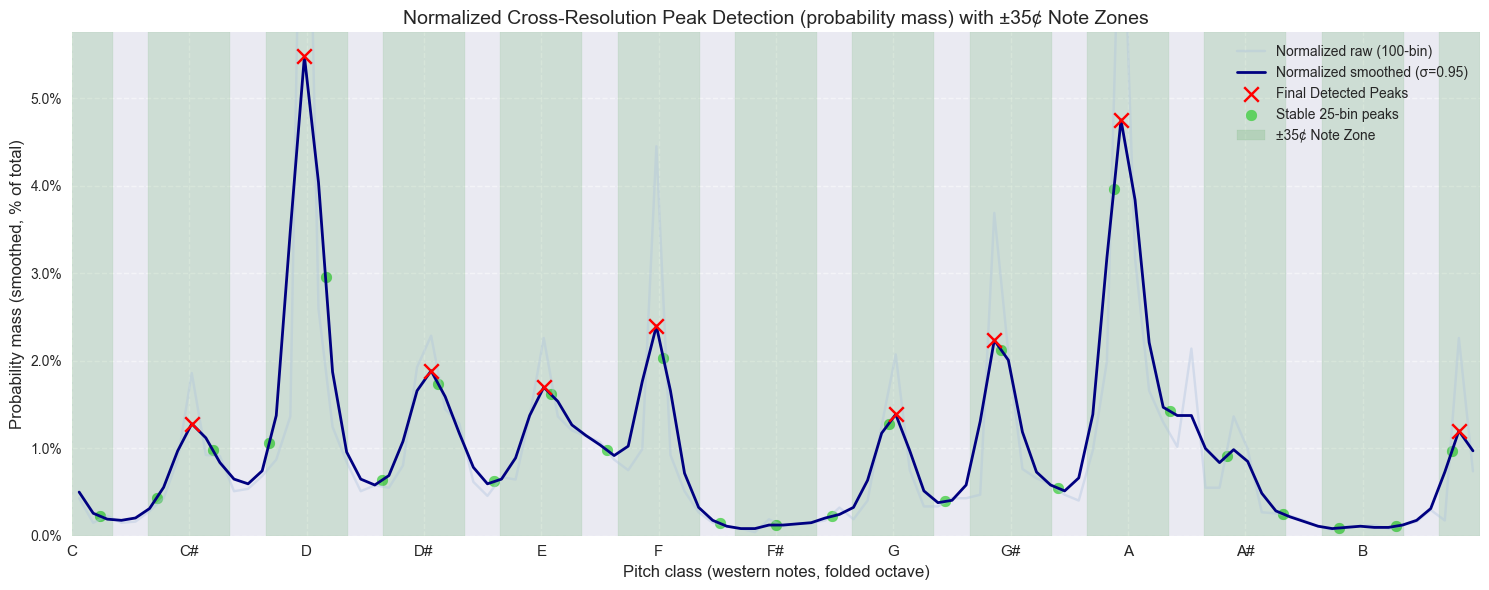

[INFO] detected_peak_count = 9

Found 11 precise peaks (100-bin) and 9 stable regions (25-bin).
Validated 9 final peaks.
Pitch-class candidates passed to next stage (±35¢ rule): [0, 1, 2, 3, 4, 5, 7, 8, 9]


In [105]:
import librosa
from collections import defaultdict

# The canonical form is the lexicographically smallest rotation of the pattern.
def get_canonical_intervals(intervals):
    if not isinstance(intervals, tuple) or not intervals:
        return tuple()
    return min(tuple(np.roll(intervals, i)) for i in range(len(intervals)))

# load the processed rāga hash table
raga_df = pd.read_csv('/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/db/raga_list_final.csv')

#Build a new lookup: canonical interval pattern → list of matching rāgas
# Each rāga is stored as a dictionary containing its name and specific interval pattern
raga_interval_db = defaultdict(list)

for _, row in raga_df.iterrows():
    if 'mask' in raga_df.columns:
        mask_abs = tuple(map(int, row['mask'].split(',')))
        name = row['raga']
    else:
        mask_abs = tuple(int(row[str(i)]) for i in range(12))
        name = row['names']

    # Get the pitch classes (swaras) from the rāga's definition
    p = np.where(np.array(mask_abs) == 1)[0]
    if len(p) < 2:  # Rāga needs at least two notes
        continue
    
    p.sort()
    # Calculate the rāga's specific interval pattern
    intervals = tuple(np.mod(np.diff(np.concatenate((p, [p[0] + 12]))), 12))

    # Ensure the scale is valid (intervals sum to an octave)
    if sum(intervals) != 12:
        continue

    # Find the canonical representation for this rāga's scale structure
    canonical_pattern = get_canonical_intervals(intervals)
    
    # Store the rāga's info under its canonical pattern
    raga_interval_db[canonical_pattern].append({'name': name, 'intervals': intervals})

# The original 'raga_masks' is no longer used in its old form.
raga_masks = raga_interval_db
print("Successfully built the new interval-based rāga database.")

# MODIFIED Cell 6: Compute both High- and Low-Resolution Histograms

# --- Settings for peak detection ---
num_bins_high_res = 100   # For precise, smoothed peak finding
num_bins_low_res = 25     # For stable, raw peak region finding
sigma = 0.95            # Smoothing amount for the high-res histogram
peak_tolerance_cents = 30 # How close a high-res peak must be to a low-res peak (in cents)

# --- Histogram Calculations ---
midi_vals_mel = librosa.hz_to_midi(valid_freqs_v)
cent_values = (midi_vals_mel % 12) * 100

# Create the high-resolution histogram (100 bins)
H_mel_100, bin_edges_100 = np.histogram(cent_values, bins=num_bins_high_res, range=(0, 1200))

# Create the low-resolution histogram (25 bins)
H_mel_25, bin_edges_25 = np.histogram(cent_values, bins=num_bins_low_res, range=(0, 1200))

print(f"Computed high-resolution histogram with shape: {H_mel_100.shape}")
print(f"Computed low-resolution histogram with shape: {H_mel_25.shape}")

# Cell 7: Detect peaks to get pitch-class candidates
# REPLACEMENT for Cell 7: Cross-Resolution Peak Detection and Visualization

from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# --- Part A: Find Peaks in Both Histograms and Convert to Cents ---

# 1. Process the HIGH-RESOLUTION histogram to get precise peak candidates
smoothed_H_100 = gaussian_filter1d(H_mel_100, sigma=sigma, mode='wrap')
bin_centers_100 = (bin_edges_100[:-1] + bin_edges_100[1:]) / 2
smoothed_peaks_100_indices = []
for i in range(num_bins_high_res):
    prev, next = (i - 1) % num_bins_high_res, (i + 1) % num_bins_high_res
    if smoothed_H_100[i] > smoothed_H_100[prev] and smoothed_H_100[i] > smoothed_H_100[next]:
        smoothed_peaks_100_indices.append(i)
# Get the cent values of these precise peaks
smoothed_peaks_cents = bin_centers_100[smoothed_peaks_100_indices]

# map every high-res bin center (0..1200 cents) to a pitch-class 0..11
cent_to_pc = np.round(bin_centers_100 / 100.0).astype(int) % 12
# sanity check
assert len(cent_to_pc) == len(H_mel_100)


# 2. Process the LOW-RESOLUTION histogram to get stable validation regions
bin_centers_25 = (bin_edges_25[:-1] + bin_edges_25[1:]) / 2
raw_peaks_25_indices = []
for i in range(num_bins_low_res):
    prev, next = (i - 1) % num_bins_low_res, (i + 1) % num_bins_low_res
    if H_mel_25[i] > H_mel_25[prev] and H_mel_25[i] > H_mel_25[next]:
        raw_peaks_25_indices.append(i)
# Get the cent values of these stable peaks
raw_peaks_cents = bin_centers_25[raw_peaks_25_indices]


# --- CONFIG (shared for all sections) ---
note_centers = np.arange(0, 1200, 100)  # Sa, re, Re, etc.
tolerance_cents = 35
peak_tolerance_cents = 30  # low/high-res match tolerance

# --- Part B: Validate Precise Peaks using Stable Peaks + ±35¢ Note Center Rule ---
final_peak_indices_100 = []
for i, sp_cent in zip(smoothed_peaks_100_indices, smoothed_peaks_cents):
    # Step 1: Check against stable low-res peaks
    is_validated = any(abs(sp_cent - rp_cent) <= peak_tolerance_cents for rp_cent in raw_peaks_cents)
    if not is_validated:
        continue

    # Step 2: Check against nearest ideal note center (±35¢ circular)
    diffs = np.abs((sp_cent - note_centers + 600) % 1200 - 600)
    if np.min(diffs) <= tolerance_cents:
        final_peak_indices_100.append(i)

import matplotlib.ticker as mtick

# --- NORMALIZED PLOTTING (replace previous Part C) ---
# Use the smoothed high-res data already computed (smoothed_H_100).
# Normalize the smoothed curve so it represents probability mass (sum -> 1).
smoothed_H_100_norm = smoothed_H_100.astype(float)
total = smoothed_H_100_norm.sum()
if total <= 0:
    smoothed_H_100_plot = smoothed_H_100_norm  # avoid division by zero
else:
    smoothed_H_100_plot = smoothed_H_100_norm / total

# Also compute a normalized raw curve for reference (optional)
H_mel_100_norm = H_mel_100.astype(float) / (H_mel_100.sum() + 1e-12)

print("Generating *normalized* histogram plot with Western-note x-axis and ±35¢ note zones...")

NOTE_NAMES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
plt.figure(figsize=(15, 6))

# Plot normalized raw and normalized smoothed curves
plt.plot(bin_centers_100, H_mel_100_norm, color='lightsteelblue', alpha=0.4, label='Normalized raw (100-bin)')
plt.plot(bin_centers_100, smoothed_H_100_plot, color='navy', linewidth=2, label=f'Normalized smoothed (σ={sigma})')

# Plot final validated peaks (x positions same; y from normalized-smoothed curve)
peak_x_values = bin_centers_100[final_peak_indices_100]
peak_y_values_plot = smoothed_H_100_plot[final_peak_indices_100]
plt.scatter(peak_x_values, peak_y_values_plot, color='red', s=110, marker='x',
            zorder=6, label='Final Detected Peaks')

# Plot stable 25-bin low-res peak centers (map to normalized-smoothed y for display)
low_centers = bin_centers_25
low_vals_plot = np.interp(low_centers, bin_centers_100, smoothed_H_100_plot)
plt.scatter(low_centers, low_vals_plot, color='limegreen', s=60, marker='o', alpha=0.7, label='Stable 25-bin peaks')

# Draw ±tolerance shaded bands for each note center
for idx, center in enumerate(note_centers):
    low = (center - tolerance_cents) % 1200
    high = (center + tolerance_cents) % 1200
    if low < high:
        plt.axvspan(low, high, color='green', alpha=0.12, label='±35¢ Note Zone' if idx == 0 else "")
    else:
        plt.axvspan(0, high, color='green', alpha=0.12, label='±35¢ Note Zone' if idx == 0 else "")
        plt.axvspan(low, 1200, color='green', alpha=0.12)

# X-axis: Western note labels at every 100 cents (0..1100)
xticks_positions = np.arange(0, 1200, 100)
plt.xticks(ticks=xticks_positions, labels=NOTE_NAMES, fontsize=11)

# Y-axis: show probability mass as percentage (sum of smoothed curve = 1)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))  # 0..1 -> 0%..100%
plt.ylabel("Probability mass (smoothed, % of total)", fontsize=12)

plt.title("Normalized Cross-Resolution Peak Detection (probability mass) with ±35¢ Note Zones", fontsize=14)
plt.xlabel("Pitch class (western notes, folded octave)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Legend: avoid duplicates
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.xlim(0, 1200)
plt.ylim(0, max(smoothed_H_100_plot.max() * 1.05, 0.01))  # small lower bound to keep scale visible
plt.tight_layout()
plt.show()



# --- Part D: Final Output for Downstream Cells ---
final_peak_cents = bin_centers_100[final_peak_indices_100]
pc_cand = set()

for cent_val in final_peak_cents:
    diffs = np.abs((cent_val - note_centers + 600) % 1200 - 600)  # circular diff
    nearest_idx = np.argmin(diffs)
    if diffs[nearest_idx] <= tolerance_cents:
        pc_cand.add(nearest_idx % 12)  # pitch class index

pc_cand = sorted(pc_cand)

cent_to_pc = np.round(bin_centers_100 / 100).astype(int) % 12
pc_cand = sorted(list({cent_to_pc[i] for i in final_peak_indices_100}))

# detected peak count from previous peak-detection step (if available)
if 'pc_cand' in globals():
    detected_peak_count = len(pc_cand)

print(f"[INFO] detected_peak_count = {detected_peak_count}")


print(f"\nFound {len(smoothed_peaks_cents)} precise peaks (100-bin) and {len(raw_peaks_cents)} stable regions (25-bin).")
print(f"Validated {len(final_peak_indices_100)} final peaks.")
print(f"Pitch-class candidates passed to next stage (±{tolerance_cents}¢ rule): {pc_cand}")

detected_peak_count = len(pc_cand)


In [106]:
import pandas as pd
import numpy as np

# sanity checks
required = ['smoothed_peaks_100_indices','smoothed_peaks_cents','raw_peaks_cents',
            'final_peak_indices_100','bin_centers_100','tolerance_cents','peak_tolerance_cents']
missing = [v for v in required if v not in globals()]
if missing:
    raise RuntimeError(f"Missing variables from earlier cells: {missing}. Run the peak-detection cell first.")

rows = []
note_centers = np.arange(0, 1200, 100)
for idx, cent in zip(smoothed_peaks_100_indices, smoothed_peaks_cents):
    # distance to nearest low-res peak (25-bin)
    dist_to_lowres = np.min(np.abs(raw_peaks_cents - cent)) if len(raw_peaks_cents) else np.nan
    near_lowres = bool(dist_to_lowres <= peak_tolerance_cents)

    # distance to nearest semitone center (circular)
    diffs = np.abs((cent - note_centers + 600.0) % 1200.0 - 600.0)
    nearest_note = int(np.argmin(diffs))
    note_dist = float(diffs[nearest_note])
    within_note_tol = note_dist <= tolerance_cents

    # whether this high-res peak was included in the final validated list
    validated = idx in set(final_peak_indices_100)

    # map to pitch-class (nearest semitone)
    pc_mapped = nearest_note % 12
    note_name_map = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    rows.append({
        'highres_bin_idx': int(idx),
        'cent_position': float(cent),
        'mapped_pc': int(pc_mapped),
        'mapped_note': note_name_map[pc_mapped],
        'dist_to_lowres_peak_cents': float(dist_to_lowres),
        'near_lowres(<=peak_tol)': near_lowres,
        'dist_to_semitone_cents': note_dist,
        'within_note_tol(<=35c)': within_note_tol,
        'validated_final': bool(validated)
    })

df_peaks = pd.DataFrame(rows).sort_values(by='cent_position')
pd.set_option('display.float_format', lambda x: f"{x:0.1f}")
print(df_peaks.to_string(index=False))


 highres_bin_idx  cent_position  mapped_pc mapped_note  dist_to_lowres_peak_cents  near_lowres(<=peak_tol)  dist_to_semitone_cents  within_note_tol(<=35c)  validated_final
               8          102.0          1          C#                       18.0                     True                     2.0                    True             True
              16          198.0          2           D                       18.0                     True                     2.0                    True             True
              25          306.0          3          D#                        6.0                     True                     6.0                    True             True
              33          402.0          4           E                        6.0                     True                     2.0                    True             True
              41          498.0          5           F                        6.0                     True                     2.0          

In [107]:
# Cell 8: Build interval sequence from detected pitch-classes
P = np.array(pc_cand)
p = np.sort(P)
k = len(p)
intervals = np.mod(np.diff(np.concatenate((p, [p[0]+12]))), 12)
print(f"Detected intervals: {intervals}")

# Helper function (repeat from above, or define in a shared cell)
def get_canonical_intervals(intervals):
    if not isinstance(intervals, tuple) or not intervals:
        return tuple()
    return min(tuple(np.roll(intervals, i)) for i in range(len(intervals)))

dx_candidates = []  # list of (tonic, mask_rel, ragas)

# p is the sorted list of detected pitch classes from Cell 8
# intervals is the detected interval sequence from Cell 8
# k is the number of detected pitch classes from Cell 8
for j in range(k):
    tonic = int(p[j])
    # Consider each possible rotation of the detected intervals
    rotated_I = tuple(np.roll(intervals, -j))
    
    # Find the canonical form of the detected interval pattern
    canonical_I = get_canonical_intervals(rotated_I)

    # Look for this scale structure in our new database
    if canonical_I in raga_masks:
        # We found a potential match! Now, find the specific rāgas.
        # 'raga_group' contains all rāgas matching the canonical pattern (e.g., Bhupali, Dhani)
        raga_group = raga_masks[canonical_I]
        
        # Check which of these rāgas has the exact interval pattern we just detected
        matching_ragas = [
            raga['name'] for raga in raga_group 
            if raga['intervals'] == rotated_I
        ]
        
        if matching_ragas:
            # We have a valid candidate. Now, construct the relative mask
            # that subsequent cells expect.
            current_note = 0
            # Notes relative to the tonic at 0
            relative_notes = {0}
            for step in rotated_I[:-1]:
                current_note += step
                relative_notes.add(current_note)
            
            mask_rel = tuple(1 if i in relative_notes else 0 for i in range(12))
            
            # Add the found candidate(s) to our list
            dx_candidates.append((tonic, mask_rel, matching_ragas))

print(f"Valid interval-based inversions: {[(t, ragas) for t,_,ragas in dx_candidates]}")

# Cell 10: Compute accompaniment tonic salience for these tonics
midi_vals_acc = librosa.hz_to_midi(valid_freqs_a)
pitch_classes_acc = np.mod(np.round(midi_vals_acc), 12).astype(int)

H_acc, _ = np.histogram(pitch_classes_acc, bins=12, range=(0,12))
a_theta = {t: np.roll(H_acc, -t)[0] for t,_,_ in dx_candidates}
print(f"Accompaniment salience per tonic: {a_theta}")
Theta_prime = [t for t,a in a_theta.items() if a >= 0]

results = []
# Pre-aggregate melody histogram from high-resolution bins to 12 pitch classes
H_pc = np.zeros(12, dtype=int)
# cent_to_pc is from the peak detection cell (Cell 7)
# H_mel_100 is from the histogram creation cell (Cell 6)
for bin_index, pc in enumerate(cent_to_pc):
    H_pc[pc] += H_mel_100[bin_index] # CORRECTED

for tonic, mask_rel, ragas in dx_candidates:
    # Skip candidates whose tonic has weak support from the accompaniment
    if tonic not in Theta_prime:
        continue
    
    # create Sa-relative view of the melody's pitch distribution
    H_rot = np.roll(H_pc, -tonic)
        
    # bonus for the tonic (Sa) is always its count in the melody
    sa_bonus = H_rot[0]
    
    bonus_options = [0] # Start with 0 in case rāga has no Ma or Pa.
    if mask_rel[5] == 1:  # Check for Shuddha Ma
        bonus_options.append(H_rot[5])
    if mask_rel[6] == 1:  # Check for Tivra Ma
        bonus_options.append(H_rot[6])
    if mask_rel[7] == 1:  # Check for Pa
        bonus_options.append(H_rot[7])
    
    dominant_note_bonus = max(bonus_options)
    

    score = sa_bonus + dominant_note_bonus
        
    for raga in ragas:
        results.append({'tonic': tonic, 'raga': raga,
                        'score': score, 'salience': a_theta[tonic]})

#results sorted by Salience, then Score

if results:
    df = pd.DataFrame(results)
    print("Top 10 Rāga Candidates (Ranked by Tonic Salience, then Score):")
    
    final_ranking = df.sort_values(by=['salience', 'score'], ascending=[False, False])
    
    print(final_ranking.head(10))
else:
    print(" No matching ragas were found in the database.")

Detected intervals: [1 1 1 1 1 2 1 1 3]
Valid interval-based inversions: []
Accompaniment salience per tonic: {}
 No matching ragas were found in the database.


In [108]:
# ---------------- Tunables (unchanged) ----------------
EPS = 1e-12
ALPHA_MATCH = 0.40
BETA_PRESENCE = 0.25
GAMMA_LOGLIKE = 0.7
DELTA_EXTRA = 1.10
COMPLEX_PENALTY = 0.4
USE_PRESENCE_SUM_DIV_SQRT = True    # observed_note_score = sum(p_rescaled)/sqrt(size)
MATCH_SIZE_GAMMA = 0.25
TONIC_SALIENCE_WEIGHT = 0.12
SCALE = 1000.0
USE_PRESENCE_MEAN = False
USE_NORM_PRIMARY = True

# ---------------- WINDOW SETTINGS ----------------
WINDOW_CENTS = 35.0   # ±35 cents window around each ideal note center
BIN_SIZE_CENTS = 1.0  # 1-cent resolution for fine histogram (if we compute one)

# ---------------- Build window-limited per-note masses -> H_pc_arr ----------------
# We prefer to build cent-level histogram from one of the available upstream variables.
if 'midi_vals_v' in globals():
    midi_vals_mel = np.asarray(midi_vals_v)
    cent_vals_mel = (midi_vals_mel % 12) * 100.0
    # 1-cent bins over 0..1200
    num_bins = int(1200 / BIN_SIZE_CENTS)
    bin_edges = np.linspace(0.0, 1200.0, num_bins + 1)
    cent_hist, _ = np.histogram(cent_vals_mel, bins=bin_edges, range=(0.0, 1200.0))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
elif 'valid_freqs_v' in globals():
    freqs = np.asarray(valid_freqs_v)
    midi_vals_mel = librosa.hz_to_midi(freqs)
    cent_vals_mel = (midi_vals_mel % 12) * 100.0
    num_bins = int(1200 / BIN_SIZE_CENTS)
    bin_edges = np.linspace(0.0, 1200.0, num_bins + 1)
    cent_hist, _ = np.histogram(cent_vals_mel, bins=bin_edges, range=(0.0, 1200.0))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
elif 'H_mel_100' in globals() and 'bin_centers_100' in globals():
    # Use existing high-res histogram (100-bin) as proxy (note centers in bin_centers_100)
    cent_hist = np.asarray(H_mel_100).astype(float)
    bin_centers = np.asarray(bin_centers_100)
else:
    raise RuntimeError(
        "Need melody cent source: define one of 'midi_vals_v' (preferred), "
        "'valid_freqs_v' (Hz), or 'H_mel_100'+'bin_centers_100' in the notebook namespace."
    )

# Function to compute mass in ±WINDOW_CENTS around a note center (with wrap)
def mass_within_window_for_note(note_idx):
    center = (note_idx * 100.0) % 1200.0
    diff = np.abs(bin_centers - center)
    diff = np.minimum(diff, 1200.0 - diff)   # circular distance
    return float(np.sum(cent_hist[diff <= WINDOW_CENTS]))

# Compute raw masses for each of the 12 pitch-classes using the cent-window
note_masses_raw = np.array([mass_within_window_for_note(i) for i in range(12)], dtype=float)

# If everything is zero (no voiced frames), keep zeros to avoid divide-by-zero later
total_raw = note_masses_raw.sum()
if total_raw <= 0:
    H_pc_arr = np.zeros(12, dtype=float)
else:
    # keep H_pc_arr as raw masses (so downstream code that expects counts still works)
    H_pc_arr = note_masses_raw.copy()

# p_pc: normalized probability distribution (same formula as original code)
p_pc = (H_pc_arr + EPS) / (np.sum(H_pc_arr) + 12 * EPS)

# ---------------- accompaniment salience inputs (unchanged) ----------------
midi_vals_acc_arr = np.asarray(midi_vals_acc)   # must exist upstream
pitch_classes_acc = np.mod(np.round(midi_vals_acc_arr), 12).astype(int)
H_acc, _ = np.histogram(pitch_classes_acc, bins=12, range=(0, 12))
salience_all_tonics = {t: int(H_acc[t]) for t in range(12)}
max_acc = float(H_acc.max()) if H_acc.size and H_acc.max() > 0 else 1.0

# --- NEW: compute mean salience and only allow tonics above the mean ---
mean_salience = float(np.mean(list(salience_all_tonics.values())))
# list tonics that exceed the mean salience (strictly greater)
surviving_tonics = [t for t,a in salience_all_tonics.items() if a > mean_salience]
print(f"[INFO] mean accompaniment salience = {mean_salience:.3f}; only tonics with salience > mean will be considered")
print(f"[INFO] surviving tonics ({len(surviving_tonics)}): {surviving_tonics}")

final_results = []

# ---------------- Raga Scoring (original logic, using window-limited H_pc_arr) ----------------
for idx, row in raga_df.iterrows():
    # robust mask extraction (supports 'mask' column or 0..11 columns)
    mask_abs = None
    if 'mask' in raga_df.columns and pd.notna(row.get('mask')):
        raw = row['mask']
        if isinstance(raw, str):
            parts = [x.strip() for x in raw.split(',') if x.strip()]
            try:
                mask_abs = tuple(int(x) for x in parts)
            except Exception:
                mask_abs = None
        else:
            try:
                mask_abs = tuple(int(x) for x in list(raw))
            except Exception:
                mask_abs = None
    if mask_abs is None:
        try:
            mask_abs = tuple(int(row[i]) for i in range(12))
        except Exception:
            try:
                mask_abs = tuple(int(row[str(i)]) for i in range(12))
            except Exception:
                continue

    name = row.get('names') if 'names' in raga_df.columns else row.get('raga', f"raga_{idx}")
    mask_abs = np.array(mask_abs, dtype=int)
    if mask_abs.sum() < 2:
        continue

    # For each possible tonic rotation (masks are absolute; rotate observed distribution)
    for tonic in range(12):
        # --- NEW: skip tonics that are not above mean salience ---
        tonic_sal_check = float(salience_all_tonics.get(tonic, 0))
        if tonic_sal_check <= mean_salience:
            continue

        p_rot = np.roll(p_pc, -tonic)         # rotate observed distribution only
        raga_note_indices = np.where(mask_abs == 1)[0].tolist()
        raga_size = len(raga_note_indices)
        if 'detected_peak_count' in globals() and detected_peak_count is not None:
            # absolute difference in note counts
            size_diff = abs(raga_size - int(detected_peak_count))

            # normalize by the octave (12) so penalty is scale-invariant
            # you already have MATCH_SIZE_GAMMA as a tunable; use it to weight the penalty
            # linear penalty:
            size_penalty = MATCH_SIZE_GAMMA * (size_diff / 4.0)
        if raga_size < 2:
            continue

        # --- raw masses (unchanged) ---
        match_mass = float(np.sum(p_rot[raga_note_indices]))   # probability mass on allowed notes
        extra_mass = float(1.0 - match_mass)

        # --- presence (peak-normalized) ---
        peak = float(np.max(p_rot) + EPS)
        pres = (p_rot[raga_note_indices] / peak)
        if USE_PRESENCE_MEAN:
            observed_note_score = float(np.mean(pres)) if raga_size > 0 else 0.0
        else:
            # original behavior: sum / sqrt(size)
            observed_note_score = float(np.sum(pres) / (np.sqrt(raga_size) + EPS))

        # --- log-likelihood (unchanged) ---
        sum_logp = float(np.sum(np.log(p_rot[raga_note_indices] + EPS)))
        baseline = -np.log(12.0)
        avg_logp = sum_logp / (raga_size + EPS)
        loglike_norm = 1.0 + (avg_logp / (-baseline + EPS))
        loglike_norm = max(0.0, min(1.0, loglike_norm))

        # --- complexity penalty (unchanged) ---
        complexity_pen = max(0.0, (raga_size - 5) / 12.0)

        # --- primary score (unchanged) ---
        if USE_NORM_PRIMARY:
            prim = float(p_rot[0])
            bonus_options = [0.0]
            if mask_abs[5] == 1: bonus_options.append(float(p_rot[5]))
            if mask_abs[6] == 1: bonus_options.append(float(p_rot[6]))
            if mask_abs[7] == 1: bonus_options.append(float(p_rot[7]))
            primary_score_norm = prim + max(bonus_options)
        else:
            H_rot_counts = np.roll(H_pc_arr, -tonic)
            sa_bonus = float(H_rot_counts[0])
            bonus_options = [0.0]
            if mask_abs[5] == 1: bonus_options.append(float(H_rot_counts[5]))
            if mask_abs[6] == 1: bonus_options.append(float(H_rot_counts[6]))
            if mask_abs[7] == 1: bonus_options.append(float(H_rot_counts[7]))
            primary_score_norm = sa_bonus + max(bonus_options)

        # --- combine into fit_norm (original weights) ---
        fit_norm = (ALPHA_MATCH * match_mass +
                    BETA_PRESENCE * observed_note_score +
                    GAMMA_LOGLIKE * loglike_norm) - (
                    DELTA_EXTRA * extra_mass +
                    COMPLEX_PENALTY * complexity_pen +
                    size_penalty)

        # accompaniment salience boost (recompute tonic_sal for output)
        tonic_sal = float(salience_all_tonics.get(tonic, 0))
        tonic_sal_norm = tonic_sal / (max_acc + EPS)
        fit_norm += TONIC_SALIENCE_WEIGHT * tonic_sal_norm

        fit_norm = max(-1.0, min(1.0, fit_norm))
        fit_score = float(fit_norm * SCALE)

        final_results.append({
            'raga': name,
            'tonic': int(tonic),
            'salience': int(tonic_sal),
            'fit_score': fit_score,
            'primary_score': float(primary_score_norm),
            'match_mass': match_mass,
            'extra_mass': extra_mass,
            'observed_note_score': observed_note_score,
            'loglike_norm': loglike_norm,
            'raga_size': raga_size,
            'match_diff': size_diff,
            'complexity_pen': complexity_pen,
        })
df_final = pd.DataFrame(final_results)

# ---------------- Output ----------------
# choose sorting order depending on 'fusion' flag
if 'fusion' in globals() and fusion is False:
    # original behavior: primary_score first
    final_ranking = df_final.sort_values(
        by=['primary_score', 'salience', 'fit_score'],
        ascending=[False, False, False]
    )
    print("[INFO] Ranking: primary_score -> salience -> fit_score (fusion=False)")
else:
    # salience-first ranking (used when fusion!=False or fusion not defined)
    final_ranking = df_final.sort_values(
        by=['salience', 'fit_score', 'primary_score'],
        ascending=[False, False, False]
    )
    print("[INFO] Ranking: salience -> fit_score -> primary_score (fusion!=False)")
print(final_ranking.head(80).to_string(index=True))


[INFO] mean accompaniment salience = 733.250; only tonics with salience > mean will be considered
[INFO] surviving tonics (4): [1, 2, 3, 9]
[INFO] Ranking: salience -> fit_score -> primary_score (fusion!=False)
                                                                                 raga  tonic  salience  fit_score  primary_score  match_mass  extra_mass  observed_note_score  loglike_norm  raga_size  match_diff  complexity_pen
37                                                                        ["Ramkali"]      2      4016      440.0            0.4         0.8         0.2                  1.3           0.0          9           0             0.3
17                                                                  ["Multani, Todi"]      2      4016      434.3            0.4         0.8         0.2                  1.5           0.1          7           2             0.2
105                                                                 ["Chandranandan"]      2      4016      

/var/folders/dr/7jrw49755h70bsy03x6hy14c0000gn/T/ipykernel_17527/1679476798.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mask_abs = tuple(int(row[i]) for i in range(12))
